# Mean Shift
Mean Shift is an unsupervised clustering algorithm that aims to discover blobs in a smooth density of samples. It is a centroid-based algorithm that works by updating candidates for centroids to be the mean of the points within a given region (also called bandwidth). These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids. Therefore contrary to KMeans, we don't need to choose the number of clusters ourselves.

## Mean Shift Steps
On a high level, Mean Shift works as follows:

1. Create a sliding window/cluster for each data-point
2. Each of the sliding windows is shifted towards higher density regions by shifting their centroid (center of the sliding window) to the data-points' mean within the sliding window. This step will be repeated until no shift yields a higher density (number of points in the sliding window)
3. Selection of sliding windows by deleting overlapping windows. When multiple sliding windows overlap, the window containing the most points is preserved, and the others are deleted.
4. Assigning the data points to the sliding window in which they reside.


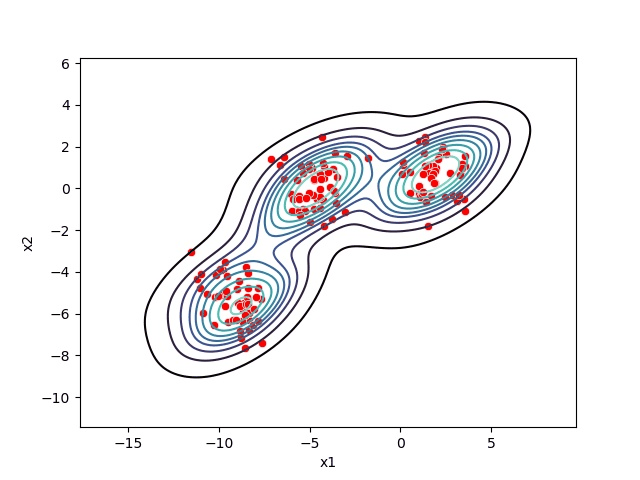

In [9]:
from IPython.display import Image 
pil_img = Image(filename='ms.gif.png')
display(pil_img)

## Kernel Density Estimation
What Mean Shift is doing is shifting the windows to a higher density region by shifting their centroid (center of the sliding window) to the mean of the data-points inside the sliding window. We can also look at this by thinking of our data points as a probability density function.


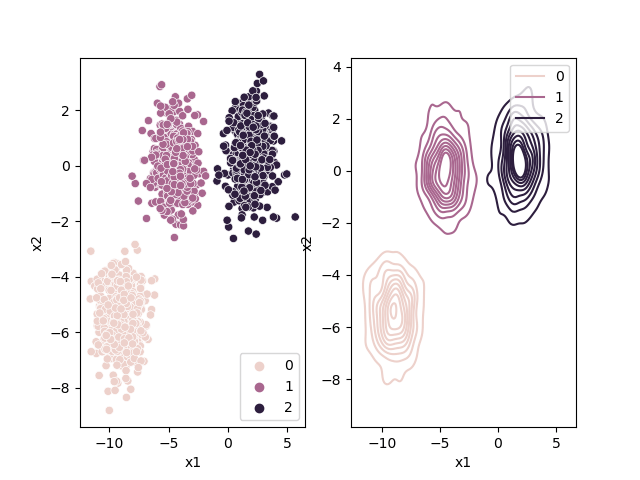

In [10]:
pil_img = Image(filename='ms2.png')
display(pil_img)

## Choosing the right bandwidth / radius
Depending on the bandwidth, the resulting clusters can look quite different. As an extreme case, imagine that we choose an extremely small bandwidth. This will result in each point having its own cluster. On the other hand, if we use a huge bandwidth, there will only be one cluster containing all the data-points.

Below you can see an image of different bandwidth values (not as extreme cases then mentioned above):



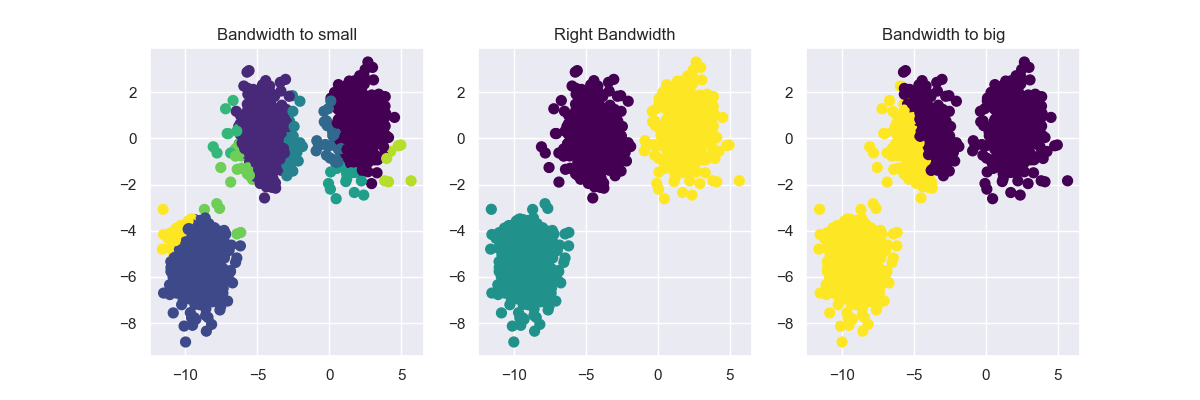

In [11]:
pil_img = Image(filename='ms3.png')
display(pil_img)

## Advantages
Mean Shift is a simple cluster method that works very well on spherical-shaped data. Furthermore, it automatically selects the number of clusters contrary to other clustering algorithms like KMeans. Also, the output of Mean Shift is not dependent on the initialization since, at the start, each point is a cluster.

## Implementation

In [27]:
# import libraries
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import  MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

In [28]:
# path 
data_dict_path = './data-dictionary.csv'
country_path = './Country-data.csv'

In [29]:
# read csv files
dict_df = pd.read_csv(data_dict_path)
df = pd.read_csv(country_path)

In [30]:
# first few rows of dictionary dataset
dict_df.head()

,Column Name,Description
0,country,Name of the country
1,child_mort,Death of children under 5 years of age per 100...
2,exports,Exports of goods and services per capita. Give...
3,health,Total health spending per capita. Given as %ag...
4,imports,Imports of goods and services per capita. Give...


In [31]:
# first few rows of countrty dataset
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [32]:
# shape of dataset
df.shape

(167, 10)

In [33]:
#some basic info
df.info()
print(50*'-')
dict_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Column Name  10 non-null     object
 1   Description  10 non-null     object
dtypes: object(2)
memory

In [34]:
#some basic statistical data
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [35]:
#null value 
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [36]:
#null value
dict_df.isnull().sum()

Column Name    0
Description    0
dtype: int64

Let's see the number of unique countries present in our dataset

In [37]:
#number of unique countries
df['country'].nunique()

167

As we are going to use Unsupervised learning technique we don't need the country column here.So we are going to drop it

In [38]:
#drop country column
data=df.drop(['country'],axis=1)

In [39]:
data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


<Axes: >

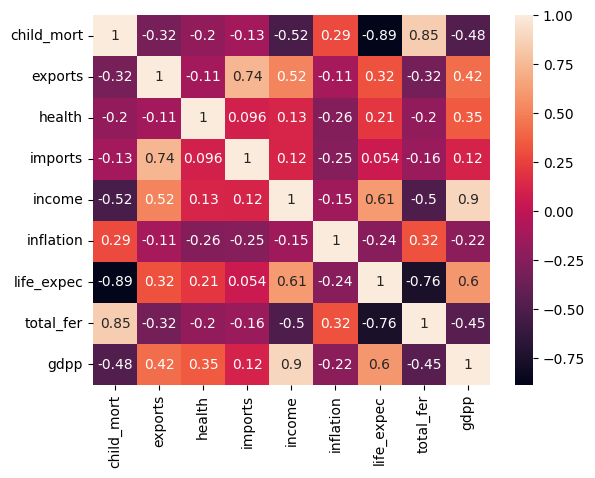

In [40]:
#correlation 
corr_matrix=data.corr()
sns.heatmap(corr_matrix,annot=True)

From above we can conclude that:<br>

1. gdpp and income,imports and exports,child_mort and total_fert are highly positive correlated<br>
2. whereas life_expec and child_mort are highly negative correlated

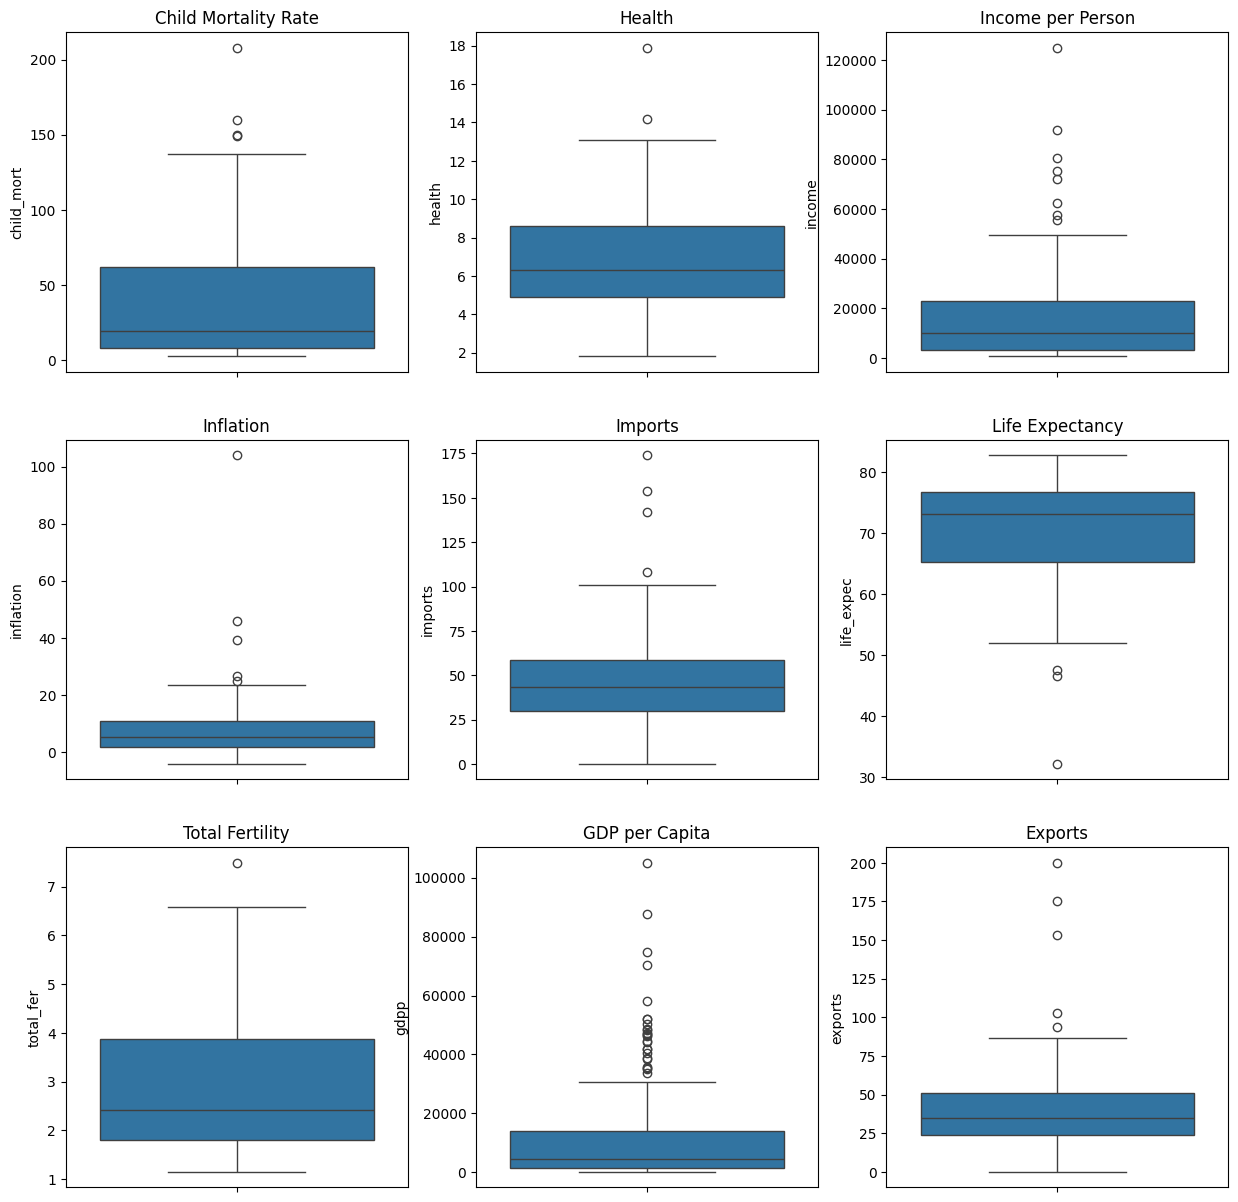

In [41]:
#box plot
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
bp=sns.boxplot(y=df.child_mort,ax=ax[0, 0])
ax[0, 0].set_title('Child Mortality Rate')
bp=sns.boxplot(y=df.health,ax=ax[0, 1])
ax[0, 1].set_title('Health')
bp=sns.boxplot(y=df.income,ax=ax[0, 2])
ax[0,2].set_title('Income per Person')
bp=sns.boxplot(y=df.inflation,ax=ax[1, 0])
ax[1,0].set_title('Inflation')
bp=sns.boxplot(y=df.imports,ax=ax[1,1])
ax[1, 1].set_title('Imports')
s=sns.boxplot(y=df.life_expec,ax=ax[1, 2])
ax[1,2].set_title('Life Expectancy')
s=sns.boxplot(y=df.total_fer,ax=ax[2,0])
ax[2,0].set_title('Total Fertility')
s=sns.boxplot(y=df.gdpp,ax=ax[2, 1])
ax[2,1].set_title('GDP per Capita')
s=sns.boxplot(y=df.exports,ax=ax[2,2])
ax[2,2].set_title('Exports')
plt.show()

From above box-plots we can see that their are so many outliers in our dataset.Most of the outliers are in income per person,GDP per captia and Exports.Now we can remove the outliers but we are not going to do it as our dataset is very small (167 rows only)

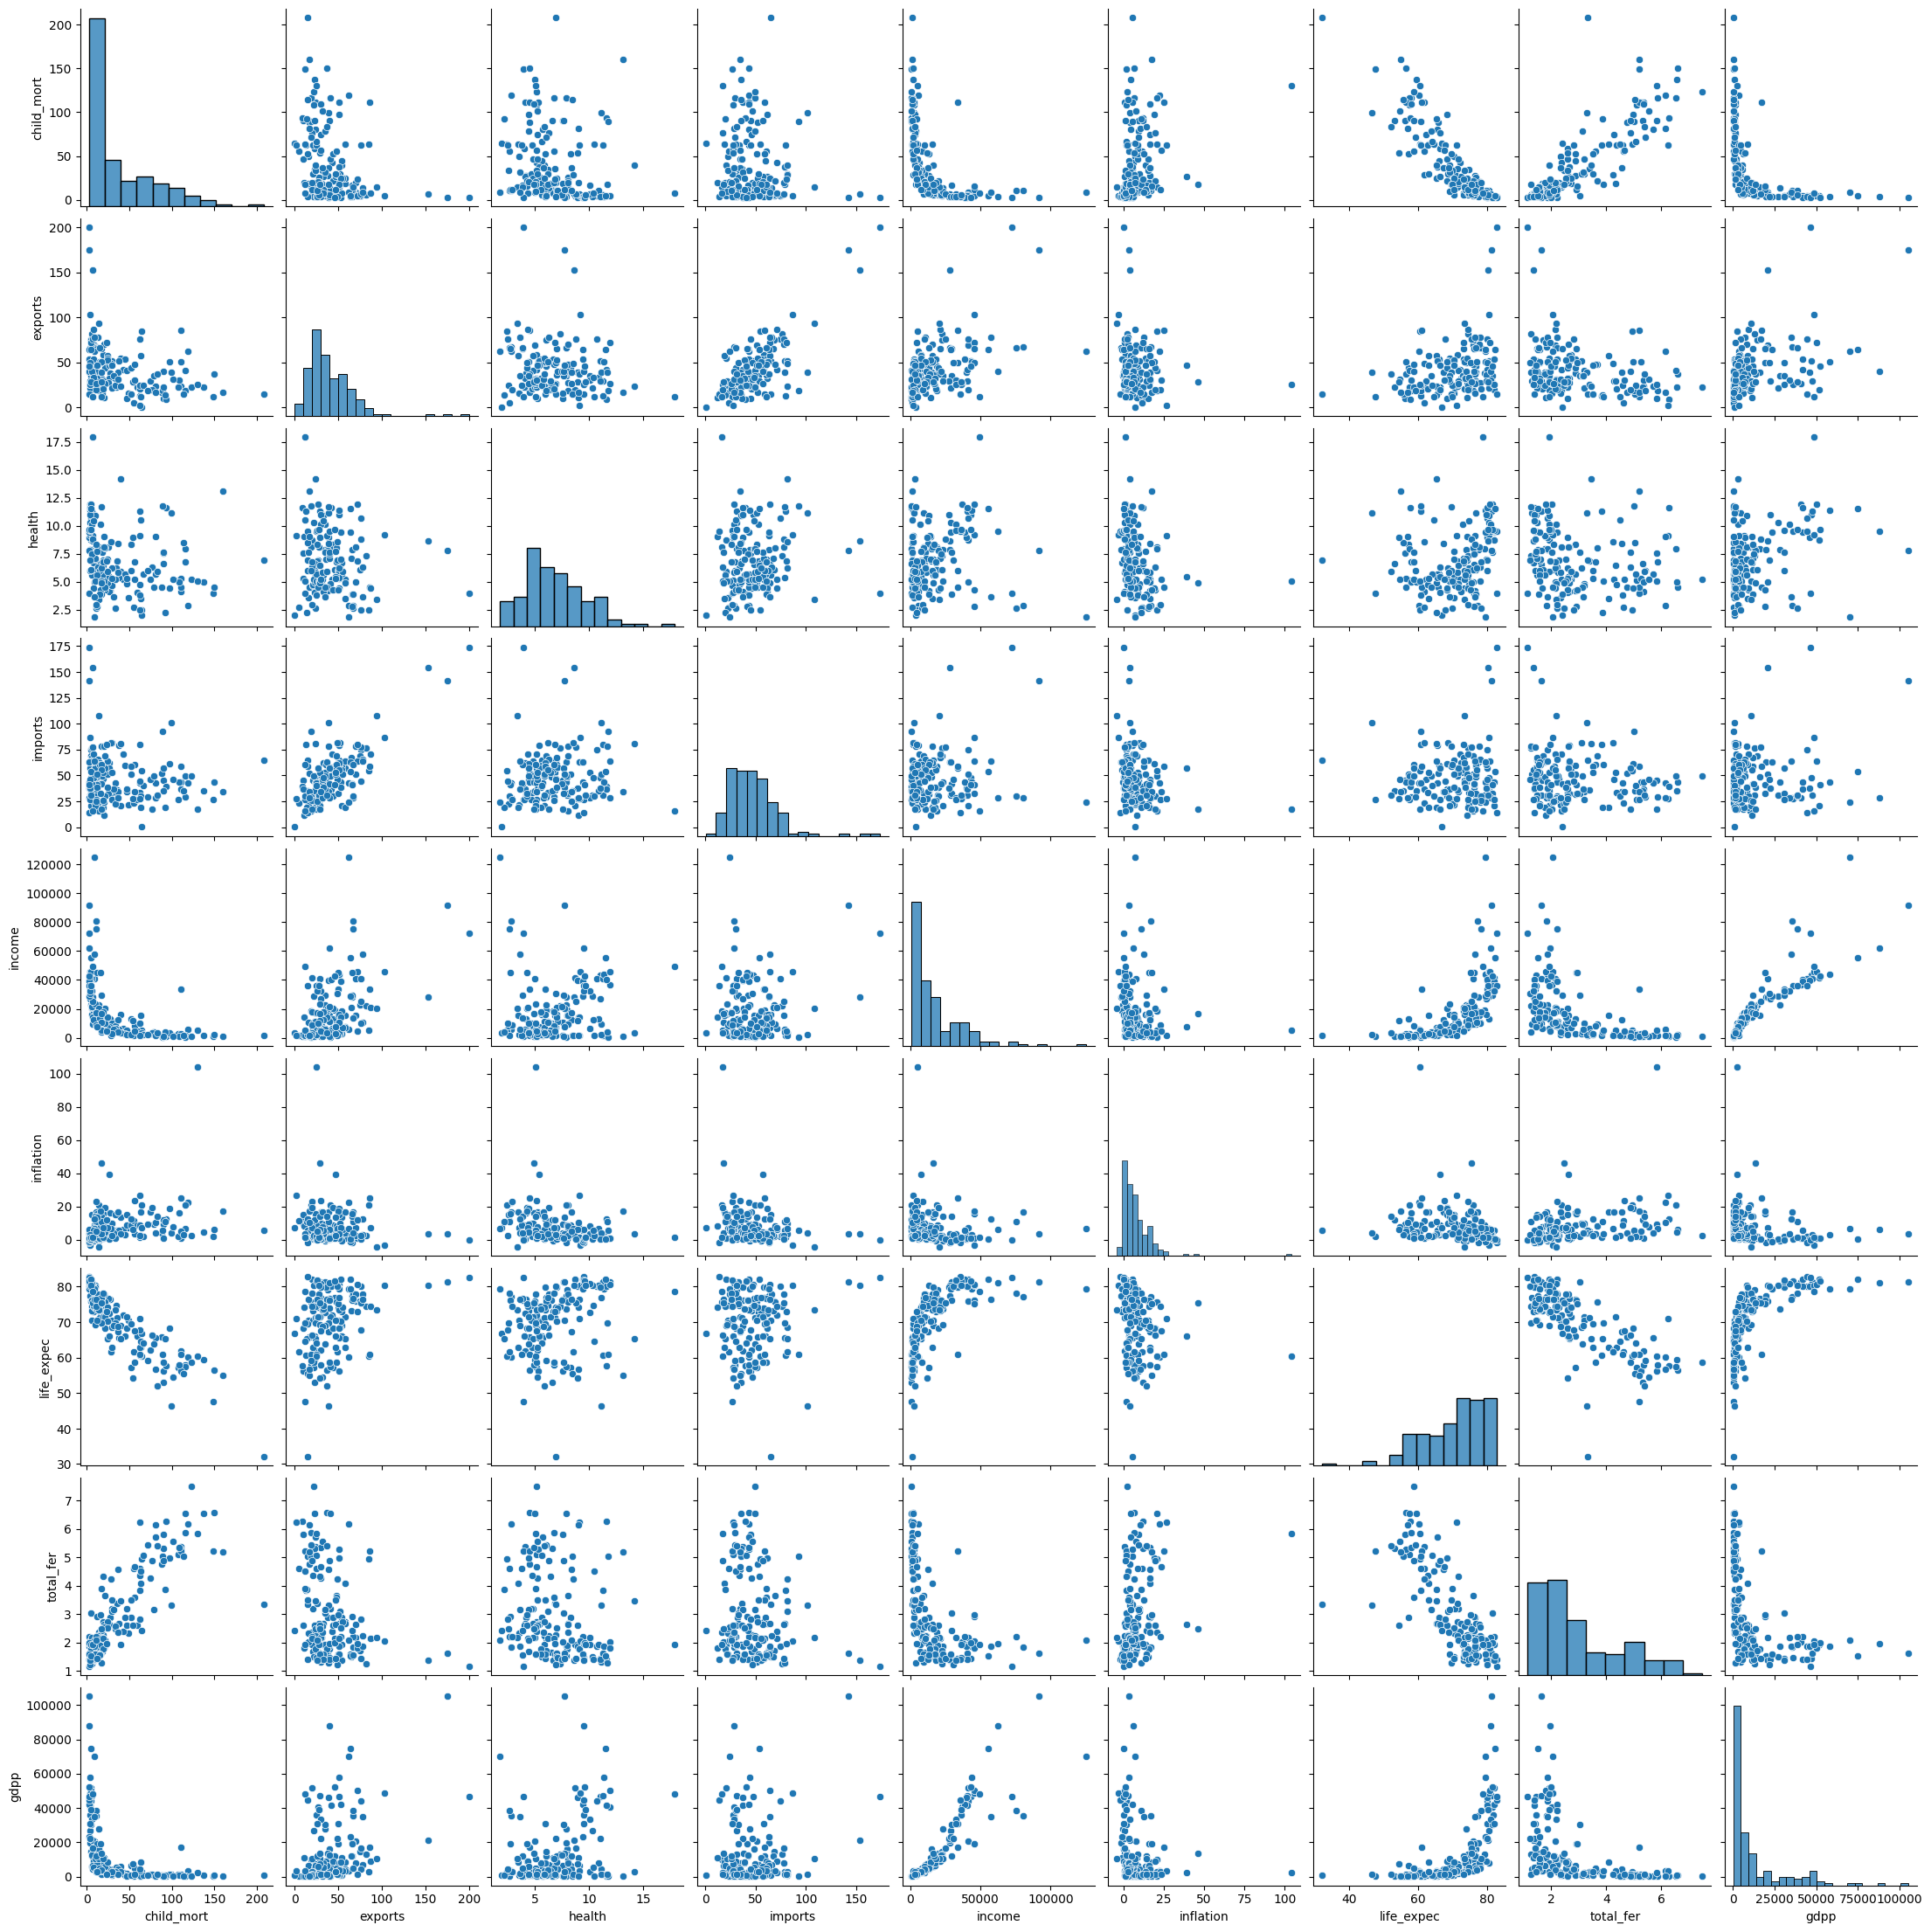

In [42]:
sns.pairplot(df)

# Scaling data

Our dataset is not scaled some values are much bigger than others,if we will not scale our data our model will not going to perform well.So now we are are going to scale our data for this we are going to use a StandardScaler library<br>
**StandardScaler** transform the data such the the mean will be 0 and variance will be 1.

**Note:-** Scaling data is necessary just for the algorithms which is based on the distance like K-means clustering and Hierarchical clustering

In [43]:
#scaling data
scaling=StandardScaler()
scaled=scaling.fit_transform(data)

In [44]:
scaled_df=pd.DataFrame(scaled,columns=data.columns)

# princt scaled dataset
scaled_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


# Mean Shift

In [45]:
list_sil = []
list_davies = []
list_ch = []
list_n = []
list_noise = []
list_eps = []

for i in range(2, 1000, 50) :
    bandwidth = estimate_bandwidth(scaled_df, quantile=0.2, n_samples=i)
    if bandwidth > 0.5 :
        meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(scaled_df)
        
        labels = meanshift.labels_
        if len(np.unique(labels)) > 1 :
            # Number of clusters in labels, ignoring noise if present.
            n = len(np.unique(meanshift.labels_))
            print('n_sample : ', n, 'Started')
            print('i=', i)
            
            sil = silhouette_score(scaled_df, meanshift.labels_)
            davies = davies_bouldin_score(scaled_df, meanshift.labels_)
            ch = calinski_harabasz_score(scaled_df, meanshift.labels_)
            
            list_sil.append(sil)
            list_davies.append(davies)
            list_ch.append(ch)
            list_n.append(n)
            print("sil : ", sil)
            print('davies : ', davies)
            print('ch : ', ch)
            print('_'*45)
    
    

print('END')

n_sample :  7 Started
i= 52
sil :  0.18985723165284152
davies :  0.7699909040035351
ch :  19.799492777111567
_____________________________________________
n_sample :  6 Started
i= 102
sil :  0.24189521505849892
davies :  0.778247326069707
ch :  16.554022205021372
_____________________________________________
n_sample :  6 Started
i= 152
sil :  0.24189521505849892
davies :  0.778247326069707
ch :  16.554022205021372
_____________________________________________
n_sample :  7 Started
i= 202
sil :  0.22341472066802068
davies :  0.713804234938258
ch :  13.678264332494436
_____________________________________________
n_sample :  7 Started
i= 252
sil :  0.22341472066802068
davies :  0.713804234938258
ch :  13.678264332494436
_____________________________________________
n_sample :  7 Started
i= 302
sil :  0.22341472066802068
davies :  0.713804234938258
ch :  13.678264332494436
_____________________________________________
n_sample :  7 Started
i= 352
sil :  0.22341472066802068
davies :  0.71

As we can see the elbow or a knee like bend is at 3.So choosing 3 as a number of clusters 

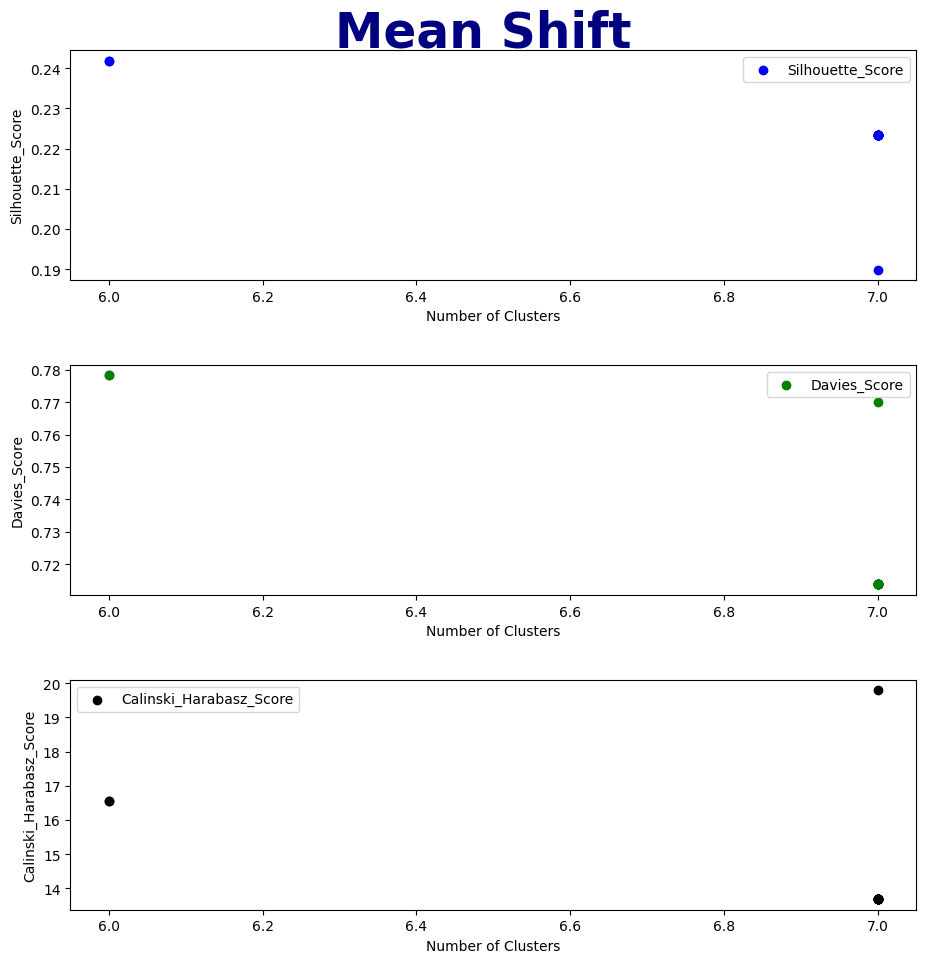

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 10))
fig.tight_layout(pad=4.0)
fig.suptitle('Mean Shift', fontsize=35, color='navy', fontweight='bold')


ax1.scatter(list_n, list_sil, label='Silhouette_Score', color='blue') # plot 1 : silhouette
ax1.legend()
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette_Score')


ax2.scatter(list_n, list_davies, label='Davies_Score', color='green') # plot 2 : Davies
ax2.legend()
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Davies_Score')



ax3.scatter(list_n, list_ch, label='Calinski_Harabasz_Score', color='black') # plot 3 : Calinski_Harabasz_Score
ax3.legend()
ax3.set_xlabel('Number of Clusters')
ax3.set_ylabel('Calinski_Harabasz_Score')



plt.show()

In [47]:
print('Best n_cluster by mean shift : ', list_n[list_sil.index(max(list_sil))])

Best n_cluster by mean shift :  6


In [48]:
meanshift_sil_score = max(list_sil)
meanshift_davies_score = max(list_davies)
meanshift_ch_score = max(list_ch)

In [49]:
print("Silhouette Score", meanshift_sil_score)
print("Calinski Harabasz Score", meanshift_ch_score )
print("Davies Score", meanshift_davies_score)


Silhouette Score 0.24189521505849892
Calinski Harabasz Score 19.799492777111567
Davies Score 0.778247326069707
